In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


class MixtureDensityNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_hidden=1, n_gaussians=1):
        super(MixtureDensityNetwork, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # This allows us to easily have multiple hidden layers 
        self.hidden = nn.ModuleList()
        self.hidden.append(nn.Linear(input_dim, hidden_dim))
        for k in range(n_hidden - 1):
            self.hidden.append(nn.Linear(hidden_dim, hidden_dim))
            
        self.output_dim = output_dim
        self.n_gaussians = n_gaussians

        self.pi_layer = nn.Linear(hidden_dim, n_gaussians)
        self.mu_layer = nn.Linear(hidden_dim, n_gaussians)
        self.sigma_layer = nn.Linear(hidden_dim, n_gaussians)

    def emb(self, x):
        for layer in self.hidden:
            x = F.sigmoid(layer(x))
        return x

    def forward(self, x):
        hidden = self.emb(x)

        # Compute pi values
        pi = F.softmax(self.pi_layer(hidden), dim=-1)

        # Compute mu values
        mu = self.mu_layer(hidden).view(-1, self.n_gaussians, self.output_dim)

        # Compute sigma values
        sigma = F.softplus(self.sigma_layer(hidden)).view(-1, self.n_gaussians, self.output_dim)

        return pi, mu, sigma

    def loss(self, x, y):
        pi, mu, sigma = self(x)
        
        # Check for invalid values
        if torch.isnan(mu).any() or torch.isinf(mu).any():
            print("Invalid values in mu:")
            print(mu)
            raise ValueError("Invalid values in mu")
        
        if torch.isnan(sigma).any() or torch.isinf(sigma).any() or (sigma <= 0).any():
            print("Invalid values in sigma:")
            print(sigma)
            raise ValueError("Invalid values in sigma")

        # Compute the negative log likelihood
        try:
            normal = torch.distributions.Normal(mu, sigma)
            log_prob = normal.log_prob(y.unsqueeze(1).expand_as(mu))
            weighted_logprob = log_prob + torch.log(pi.unsqueeze(-1))
            
            # Use logsumexp for numerical stability
            loss = -torch.logsumexp(weighted_logprob, dim=1).sum()
        except Exception as e:
            print(f"Error in loss computation: {e}")
            print(f"pi shape: {pi.shape}, mu shape: {mu.shape}, sigma shape: {sigma.shape}")
            print(f"y shape: {y.shape}")
            raise
        
        return loss

    def sample(self, x, n_samples=1):
        pi, mu, sigma = self(x)
        
        # Choose Gaussian components based on pi
        gaussian_idx = torch.multinomial(pi, n_samples, replacement=True)
        
        # Select corresponding mu and sigma
        batch_size = x.size(0)
        batch_idx = torch.arange(batch_size).unsqueeze(1).expand(-1, n_samples)
        mu_selected = mu[batch_idx, gaussian_idx]
        sigma_selected = sigma[batch_idx, gaussian_idx]
        
        # Sample from the selected Gaussians
        normal = torch.distributions.Normal(mu_selected, sigma_selected)
        samples = normal.sample()
        
        return samples

# Generate demo data
def generate_data(n_samples=1000):
    x = np.linspace(-10, 10, n_samples)
    y = 0.1*x + 0.3 * np.sin(2 * x) + np.random.normal(0, 0.1, n_samples)
    return torch.FloatTensor(x).unsqueeze(1), torch.FloatTensor(y).unsqueeze(1)

# Train the model
def train_model(model, x, y, n_epochs=5000):
    optimizer = optim.Adam(model.parameters())
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        try:
            loss = model.loss(x, y)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 500 == 0:
                print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item():.4f}")
        except Exception as e:
            print(f"Error during training at epoch {epoch + 1}: {e}")
            break

# Visualize the results
def visualize_results(model, x, X, y):
    model.eval()
    with torch.no_grad():
        pi, mu, sigma = model(X)

    plt.figure(figsize=(10, 6))
    plt.scatter(x.numpy(), y.numpy(), alpha=0.5, label='Data')
    
    # Plot the mean of each Gaussian component
    for i in range(model.n_gaussians):
        plt.plot(x.numpy(), mu[:, i, 0].numpy(), label=f'Gaussian {i+1} mean')

    # Plot samples from the mixture
    samples = model.sample(X, n_samples=5).squeeze(-1).t()
    for i, sample in enumerate(samples):
        plt.scatter(x.numpy(), sample.numpy(), alpha=0.1, label=f'Sample {i+1}' if i == 0 else None)

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mixture Density Network Results')
    plt.legend()
    plt.show()

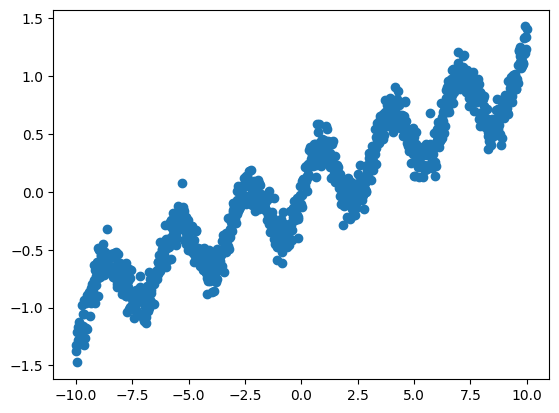

In [63]:
# Generate demo data
x, y = generate_data()

plt.scatter(x, y)

In [64]:
torch.concatenate([x, torch.sin(x)], axis=1)

tensor([[-10.0000,   0.5440],
        [ -9.9800,   0.5271],
        [ -9.9600,   0.5100],
        ...,
        [  9.9600,  -0.5100],
        [  9.9800,  -0.5271],
        [ 10.0000,  -0.5440]])

Epoch 500/5000, Loss: -119.8534
Epoch 1000/5000, Loss: -183.3412
Epoch 1500/5000, Loss: -417.4366
Epoch 2000/5000, Loss: -538.2256
Epoch 2500/5000, Loss: -626.1736
Epoch 3000/5000, Loss: -708.1749
Epoch 3500/5000, Loss: -759.5751
Epoch 4000/5000, Loss: -788.5792
Epoch 4500/5000, Loss: -819.4693
Epoch 5000/5000, Loss: -836.1958


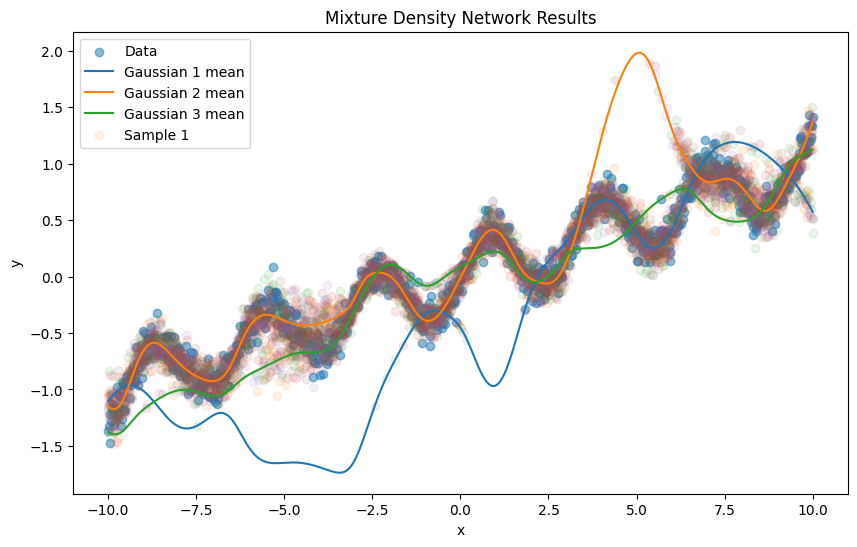

In [70]:
# Initialize and train the model
model = MixtureDensityNetwork(input_dim=2, hidden_dim=20, n_gaussians=3)
X = torch.concatenate([x, torch.sin(x)], axis=1)
train_model(model, X, y)

# Visualize the results
visualize_results(model, x, X, y)

In [78]:
from drawdata import ScatterWidget

widget = ScatterWidget()
widget

ScatterWidget()

In [71]:
pi, mu, sigma = model(X)

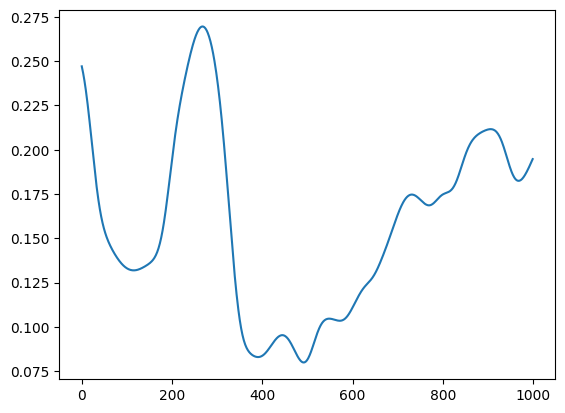

In [75]:
plt.plot(sigma.sum(axis=1).detach())